# Evaluation

In [1]:
from copy import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import config as cf
import utils as ut

In [2]:
# IO
res_main_dir = "/opt/storage/projects/o/pp7_llm/outputs/model_responses/gpt"
md_file = cf.metadata_file
md_df = pd.read_csv(md_file, sep="\t")

# color scheme for confusion matrices based on model name 
clrmap_dict = {"gpt-4o": "Greens", "gpt-35-turbo": "Blues"}

In [3]:
def plot_confusion_matrix(y_preds, y_true, labels, color_key):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  #labels_for_fig = [l[0:4]+'.' for l in labels]
  labels_for_fig = labels
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=labels_for_fig)
  #disp.plot(cmap="Purples", values_format=".2f", ax=ax, colorbar=False)
  disp.plot(cmap=clrmap_dict[color_key], values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()


## Binary classification

In [4]:
def eval_res(res_dir, color_mode):
  """
  Evaluate humor judgement results for a directory.

  Return
      (dict): With keys as follows
              "sys_orig": original system results before label postprocessing
              "sys_res": system results after preprocessing
              "ref_res": reference results
              "cm": plain text confusion matrix
  """
  assert color_mode in clrmap_dict
  sys_jmt = ut.get_judgement_info_for_dir(res_dir)
  sys_jmt_orig = copy(sys_jmt)
  sys_jmt = ["other" if kv[1] == 'no' else "comic" for kv in sorted(sys_jmt.items())]
  ref_jmt = ["other" if va == 0 else "comic" for va in md_df['comic'].tolist()]
  labels = ["comic", "other"]
  plot_confusion_matrix(sys_jmt, ref_jmt, labels, color_mode)
  # note: 0, 1 in the plain text cm are class indices,
  # NOT 0 no humor and 1 humor
  plain_cm = confusion_matrix(ref_jmt, sys_jmt, normalize="true")
  return {"sys_orig": sys_jmt_orig,
          "sys_res": sys_jmt, "ref_res": ref_jmt, "cm": plain_cm}

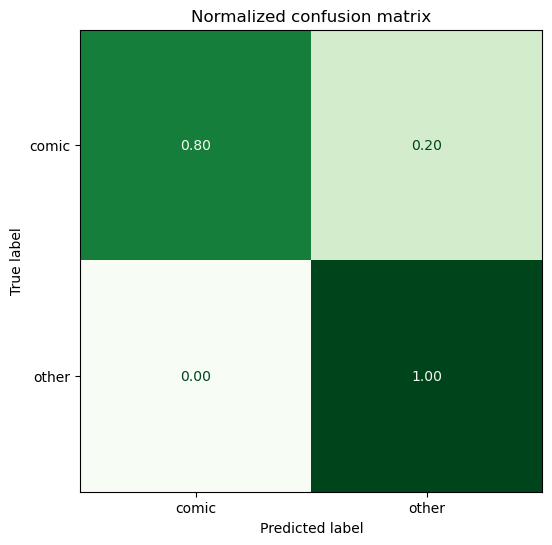

In [5]:
model_4o = "gpt-4o"
model_4o_res_dir = os.path.join(res_main_dir, model_4o)
res_4o = eval_res(model_4o_res_dir, model_4o)

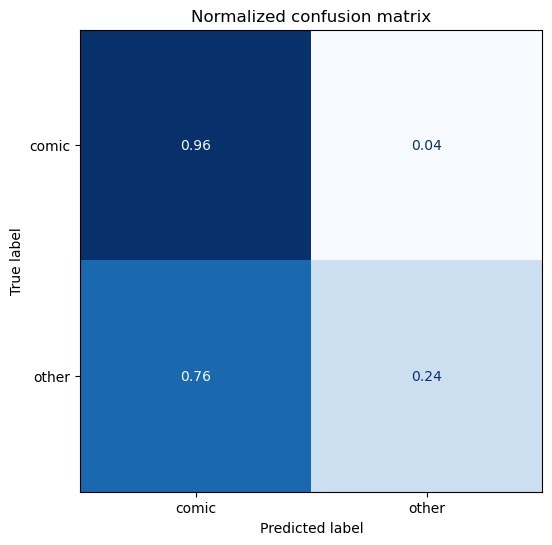

In [6]:
model_35 = "gpt-35-turbo"
model_35_res_dir = os.path.join(res_main_dir, model_35)
res_35 = eval_res(model_35_res_dir, model_35)

### Look at gpt-35-turbo errors

In [7]:
bad_centuries = []
bad_authors = []
bad_idx = []
print("\t".join(str(x) for x in ("idx", "rr", "sr", "century", "author", "title")))

for idx, (sr, rr) in enumerate(zip(res_35["sys_res"], res_35["ref_res"])):
  if rr != sr:
    century = md_df.loc[md_df['id'] == idx + 1, 'centuryBirth'].iat[0]
    author = md_df.loc[md_df['id'] == idx + 1, 'author'].iat[0]
    title = md_df.loc[md_df['id'] == idx + 1, 'title'].iat[0]
    bad_centuries.append(century)
    bad_authors.append(author)
    bad_idx.append(idx + 1)
    print("\t".join(str(x) for x in (idx, rr, sr, century, author, title)))

idx	rr	sr	century	author	title
2	comic	other	20	Jon Juaristi	Patria mía
7	other	comic	20	Jon Juaristi	Carta en Noviembre
11	other	comic	17	Matías Frigola y Picón	A la muerte del doctor Juan Pérez de Montalbán
20	comic	other	19	Manuel del Palacio	Soneto filosófico
25	other	comic	16	Camila Lucinda	Al peregrino
27	other	comic	19	Emilio Mora	Tempestades
28	other	comic	19	Manuel del Palacio	Sin esperanza
29	other	comic	18	Juan Meléndez Valdés	Las armas del amor
30	other	comic	18	Juan Meléndez Valdés	Soneto
31	other	comic	19	Julián del Casal	Medieval
32	other	comic	16	Luis Vélez de Guevara	De su comedia Celos, amor y venganza
33	other	comic	16	Francisco de Figueroa	Soneto
34	other	comic	16	Carlos de la Coba Machicao	Soneto
35	other	comic	16	Francisco de Terrazas	Soñé que una piedra me arrojaba
39	other	comic	19	Francisco Javier Ugarte y Pages	Tu mirada
41	other	comic	19	Julio Herrera y Reissig	El granjero
43	other	comic	19	Manuel José Othón	Idilio salvaje – IV
44	other	comic	19	Manuel José O

In [8]:
from collections import Counter

Counter(bad_centuries)

Counter({19: 23, 16: 7, 17: 5, 20: 2, 18: 2, 14: 1})

In [9]:
Counter(bad_authors)

Counter({'Jon Juaristi': 2,
         'Manuel del Palacio': 2,
         'Juan Meléndez Valdés': 2,
         'Francisco de Terrazas': 2,
         'Manuel José Othón': 2,
         'Rubén Darío': 2,
         'Matías Frigola y Picón': 1,
         'Camila Lucinda': 1,
         'Emilio Mora': 1,
         'Julián del Casal': 1,
         'Luis Vélez de Guevara': 1,
         'Francisco de Figueroa': 1,
         'Carlos de la Coba Machicao': 1,
         'Francisco Javier Ugarte y Pages': 1,
         'Julio Herrera y Reissig': 1,
         'José Selgas y Carrasco': 1,
         'Jacinto Verdaguer': 1,
         'José Gonzalo Roldán': 1,
         'Manuel Bernabé': 1,
         'Juan Francisco Andrés': 1,
         'Francisco de Sigüenza': 1,
         'Juan Francisco de Prado': 1,
         'Antonio Ros de Olano': 1,
         'Rosario («Crisantema») Sansores': 1,
         'Marqués de Santillana': 1,
         'Melchor Palau y Català': 1,
         'Luis Martín de la Plaza': 1,
         'Manuel Gutiérrez Náj

In [10]:
ana_dir = "../ana/ana"
fname_for_bad_jmts = os.path.join(ana_dir, "gpt35bads")
bad_model_resps = []
with open(fname_for_bad_jmts, mode="w") as infi:
  for bidx in bad_idx:
    model_resps_for_idx = [fname for fname in os.listdir(model_35_res_dir)
                           if fname.startswith("humor") and str.zfill(str(bidx), 4)
                           in fname]
    bad_model_resps.extend(model_resps_for_idx)
    for mrfi in model_resps_for_idx:
      with open(os.path.join(model_35_res_dir, mrfi), mode="r") as fi:
        for line in fi:
          pass
          #infi.write(line)

In [11]:
bad_model_resps

['humor_0003_gpt-35-turbo_3.json',
 'humor_0003_gpt-35-turbo_1.json',
 'humor_0003_gpt-35-turbo_5.json',
 'humor_0003_gpt-35-turbo_2.json',
 'humor_0003_gpt-35-turbo_4.json',
 'humor_0008_gpt-35-turbo_5.json',
 'humor_0008_gpt-35-turbo_3.json',
 'humor_0008_gpt-35-turbo_4.json',
 'humor_0008_gpt-35-turbo_2.json',
 'humor_0008_gpt-35-turbo_1.json',
 'humor_0012_gpt-35-turbo_2.json',
 'humor_0012_gpt-35-turbo_5.json',
 'humor_0012_gpt-35-turbo_3.json',
 'humor_0012_gpt-35-turbo_4.json',
 'humor_0012_gpt-35-turbo_1.json',
 'humor_0021_gpt-35-turbo_1.json',
 'humor_0021_gpt-35-turbo_4.json',
 'humor_0021_gpt-35-turbo_2.json',
 'humor_0021_gpt-35-turbo_3.json',
 'humor_0021_gpt-35-turbo_5.json',
 'humor_0026_gpt-35-turbo_1.json',
 'humor_0026_gpt-35-turbo_2.json',
 'humor_0026_gpt-35-turbo_3.json',
 'humor_0026_gpt-35-turbo_5.json',
 'humor_0026_gpt-35-turbo_4.json',
 'humor_0028_gpt-35-turbo_2.json',
 'humor_0028_gpt-35-turbo_3.json',
 'humor_0028_gpt-35-turbo_1.json',
 'humor_0028_gpt-35-